In [6]:
import sys, os, re, copy
import dill as pickle # this serializes all the functions inside the quantification dict
import numpy as np
import scipy as sp
from natsort import natsorted
from scipy.optimize import newton, minimize, fsolve
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as mcolors
import matplotlib.ticker as tck
from matplotlib.gridspec import GridSpec
palette = list(mcolors.TABLEAU_COLORS.keys())
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid", {
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': True,
 'axes.spines.top': True
})
sns.set(font_scale=1)
palette = list(mcolors.TABLEAU_COLORS.keys())
#sns.set_theme(style="ticks", palette="muted")
sns.set_style("whitegrid")
sns.set_theme(style="ticks", palette="muted")
sns.set_context("notebook", font_scale=1.5)

# Plot temporal Asp-sensor signal

### Read data and annotations

In [7]:
data_folder = 'IC_data'
anno_sheet = 'Asp-sens_temporal-annotations.xlsx'

In [8]:
well_anno = pd.read_excel(anno_sheet)
conc_res = list()
for c, r in zip(well_anno['Conc'], well_anno['Rescue']):
    if int(c) == c:
        if r != 'None':
            conc_res.append('{} + {}'.format(int(c), r))
        else:
            conc_res.append('{}'.format(int(c)))
    else:
        if r != 'None':
            conc_res.append('{} + {}'.format(c, r))
        else:
            conc_res.append('{}'.format(c))
well_anno['conc_res'] = conc_res

conc_drug = list()
for c, r in zip(well_anno['Conc'], well_anno['Drug']):
    if int(c) == c:
        if r != 'None':
            conc_drug.append('{} + {}'.format(int(c), r))
        else:
            conc_drug.append('{}'.format(int(c)))
    else:
        if r != 'None':
            conc_drug.append('{} + {}'.format(c, r))
        else:
            conc_drug.append('{}'.format(c))
well_anno['conc_drug'] = conc_drug

well_ids = natsorted(list(set(well_anno['Well'])))
well_anno.head(2)

Folder name Plate name                       Cell line Well       Drug  \
0       AS_P6      AS_P6  H1299 GOT-DKO Nuc-RFP Asp-sens   A1  Aspartate   
1       AS_P6      AS_P6  H1299 GOT-DKO Nuc-RFP Asp-sens   B1  Aspartate   

   Conc Conc unit Rescue  Nmes pre  Time to mes  max time  scatter  ci  \
0  40.0        mM   None         1          0.5        29    False  95   
1  40.0        mM   None         1          0.5        29    False  95   

   rfp fold cut  include  conf cut conc_res       conc_drug  
0            10     True       101       40  40 + Aspartate  
1            10     True       101       40  40 + Aspartate

In [9]:
plate_anno = well_anno.groupby(['Folder name', 'Plate name']).agg('max').reset_index()
plate_anno.head(2)

Folder name Plate name                Cell line Well      Drug   Conc  \
0      AS_P10     AS_P10  HT1080 Nuc-RFP Asp-sens   D6  Rotenone  200.0   
1      AS_P11     AS_P11      HT1080 Asp-sens-RFP   D6  Rotenone  200.0   

  Conc unit Rescue  Nmes pre  Time to mes  max time  scatter  ci  \
0        nM    Pyr         0          0.5        39    False  95   
1        nM    Pyr         0          0.5        30    False  95   

   rfp fold cut  include  conf cut conc_res      conc_drug  
0            10     True       101       50  50 + Rotenone  
1            10     True       101       50  50 + Rotenone

### H1299 Nuc-RFP Asp-sens Rotenone titration

IC_data/AS_P9/AS_P9_all.xlsx


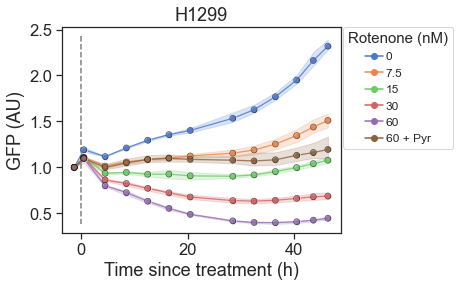

In [16]:
plate_name_sele = 'AS_P9'



row_found = False
for _, row in plate_anno.iterrows():
    if row['Plate name'] == plate_name_sele:
        row_found = True
        break
assert(row_found)
    
fnam, pnam = row['Folder name'], row['Plate name']
Nmes_pre, t_to_mes = row['Nmes pre'], row['Time to mes']

wb_name = '{}/{}/{}_all.xlsx'.format(data_folder, fnam, pnam)
sheet_name = '{}_GFP'.format(pnam)
sheet_name_rfp = '{}_RFP'.format(pnam)
print(wb_name)
#print(sheet_name)
df = pd.read_excel(wb_name, header=1, sheet_name=sheet_name)
# Fix treatment time and mask useless timepoints:
df['Elapsed'] = df['Elapsed'] - df['Elapsed'].values[Nmes_pre] + t_to_mes
time_mask = df['Elapsed'] < row['max time']
df = df[time_mask].copy()

# Find the columns for the plate:
df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
well_ids = natsorted(list(set(df_melt['Well'])))

# Mask timepoint with confluent cells:
df_rfp = pd.read_excel(wb_name, header=1, sheet_name=sheet_name_rfp)
df_rfp = df_rfp[time_mask].copy()
df_rfp.loc[:, well_ids] = df_rfp.loc[:, well_ids] / df_rfp.loc[0, well_ids]

cut_mask = df_rfp.loc[:, well_ids] < row['rfp fold cut']
df.loc[:, well_ids] = df.loc[:, well_ids][cut_mask].copy()


df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_melt = df_melt[~df_melt.isna()].copy()
df_norm = df.copy()
df_norm.loc[:, well_ids] = df.loc[:, well_ids] / df.loc[0, well_ids]
df_norm_melt = df_norm.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_norm_melt = df_norm_melt[~df_norm_melt.isna()].copy()
anno_mask = (well_anno['Folder name'] == fnam) & (well_anno['Plate name'] == pnam)
plate_data = well_anno[anno_mask].merge(df_melt, on='Well').reset_index(drop=True)
plate_data_norm = well_anno[anno_mask].merge(df_norm_melt, on='Well').reset_index(drop=True)
plate_data['GFP/RFP norm'] = plate_data_norm['GFP/RFP'].copy()
# Remove non-included wells:
plate_data = plate_data[plate_data['include']].copy()
grp_cols = list(set(plate_data.columns) - set(['GFP/RFP', 'GFP/RFP norm', 'Well']))
plate_data_avg = plate_data.groupby(grp_cols).agg(GFP_RFP_mean=('GFP/RFP', 'mean'), 
                                                  GFP_RFP_std=('GFP/RFP', 'std'), 
                                                  GFP_RFP_norm_mean=('GFP/RFP norm', 'mean'), 
                                                  GFP_RFP_norm_std=('GFP/RFP norm', 'std')).reset_index()


style = 'Drug'
markers = True
pmode = 'GFP/RFP norm'
pmode_avg = 'GFP_RFP_norm_mean'
min_sens = plate_data[pmode].min()
max_sens = plate_data[pmode].max()
hue_order = natsorted(set(plate_data['conc_res']))

fig, ax1 = plt.subplots(1, 1, figsize=(5, 3.8))
g1 = sns.lineplot(ax=ax1, data=plate_data, y=pmode, x='Elapsed', hue='conc_res', style='conc_res', \
                  zorder=9, alpha=0.8, linewidth=1.3, legend=True, \
                  errorbar=('ci', row['ci']), hue_order=hue_order, \
                  markers=["o"]*len(hue_order), dashes=[""]*len(hue_order))

g2 = sns.scatterplot(ax=ax1, data=plate_data_avg, y=pmode_avg, x='Elapsed', hue='conc_res', \
                     zorder=10, alpha=0.6, edgecolor='black', linewidth=0.7, \
                     legend=False, markers=markers, style=style, hue_order=hue_order)

g2.set_ylabel('GFP (AU)')
g2.set_xlabel('Time since treatment (h)')
g2.set_title('H1299')
sns.move_legend(g2, "upper left", bbox_to_anchor=(1.01, 1), frameon=True, ncol=1, \
                alignment='center', labelspacing=0.5, handletextpad=0.2, borderaxespad=0, \
                handlelength=1.5, title='{} ({})'.format(row['Drug'], row['Conc unit']), \
                fontsize=12, title_fontsize=15)

ax1.vlines(0, max_sens, min_sens, ls='--', color='grey')


pdf_fnam = 'temporal_plots_non-normalized/{}_GFP.pdf'.format(plate_name_sele)
fig.savefig(pdf_fnam, bbox_inches='tight')

IC_data/AS_P9/AS_P9_all.xlsx


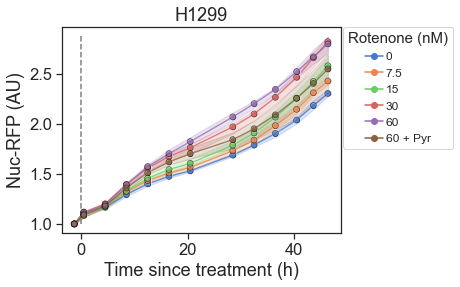

In [17]:
plate_name_sele = 'AS_P9'



row_found = False
for _, row in plate_anno.iterrows():
    if row['Plate name'] == plate_name_sele:
        row_found = True
        break
assert(row_found)
    
fnam, pnam = row['Folder name'], row['Plate name']
Nmes_pre, t_to_mes = row['Nmes pre'], row['Time to mes']

wb_name = '{}/{}/{}_all.xlsx'.format(data_folder, fnam, pnam)
sheet_name = '{}_RFP'.format(pnam)
sheet_name_rfp = '{}_RFP'.format(pnam)
print(wb_name)
#print(sheet_name)
df = pd.read_excel(wb_name, header=1, sheet_name=sheet_name)
# Fix treatment time and mask useless timepoints:
df['Elapsed'] = df['Elapsed'] - df['Elapsed'].values[Nmes_pre] + t_to_mes
time_mask = df['Elapsed'] < row['max time']
df = df[time_mask].copy()

# Find the columns for the plate:
df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
well_ids = natsorted(list(set(df_melt['Well'])))

# Mask timepoint with confluent cells:
df_rfp = pd.read_excel(wb_name, header=1, sheet_name=sheet_name_rfp)
df_rfp = df_rfp[time_mask].copy()
df_rfp.loc[:, well_ids] = df_rfp.loc[:, well_ids] / df_rfp.loc[0, well_ids]

cut_mask = df_rfp.loc[:, well_ids] < row['rfp fold cut']
df.loc[:, well_ids] = df.loc[:, well_ids][cut_mask].copy()


df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_melt = df_melt[~df_melt.isna()].copy()
df_norm = df.copy()
df_norm.loc[:, well_ids] = df.loc[:, well_ids] / df.loc[0, well_ids]
df_norm_melt = df_norm.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_norm_melt = df_norm_melt[~df_norm_melt.isna()].copy()
anno_mask = (well_anno['Folder name'] == fnam) & (well_anno['Plate name'] == pnam)
plate_data = well_anno[anno_mask].merge(df_melt, on='Well').reset_index(drop=True)
plate_data_norm = well_anno[anno_mask].merge(df_norm_melt, on='Well').reset_index(drop=True)
plate_data['GFP/RFP norm'] = plate_data_norm['GFP/RFP'].copy()
# Remove non-included wells:
plate_data = plate_data[plate_data['include']].copy()
grp_cols = list(set(plate_data.columns) - set(['GFP/RFP', 'GFP/RFP norm', 'Well']))
plate_data_avg = plate_data.groupby(grp_cols).agg(GFP_RFP_mean=('GFP/RFP', 'mean'), 
                                                  GFP_RFP_std=('GFP/RFP', 'std'), 
                                                  GFP_RFP_norm_mean=('GFP/RFP norm', 'mean'), 
                                                  GFP_RFP_norm_std=('GFP/RFP norm', 'std')).reset_index()


style = 'Drug'
markers = True
pmode = 'GFP/RFP norm'
pmode_avg = 'GFP_RFP_norm_mean'
min_sens = plate_data[pmode].min()
max_sens = plate_data[pmode].max()
hue_order = natsorted(set(plate_data['conc_res']))

fig, ax1 = plt.subplots(1, 1, figsize=(5, 3.8))
g1 = sns.lineplot(ax=ax1, data=plate_data, y=pmode, x='Elapsed', hue='conc_res', style='conc_res', \
                  zorder=9, alpha=0.8, linewidth=1.3, legend=True, \
                  errorbar=('ci', row['ci']), hue_order=hue_order, \
                  markers=["o"]*len(hue_order), dashes=[""]*len(hue_order))

g2 = sns.scatterplot(ax=ax1, data=plate_data_avg, y=pmode_avg, x='Elapsed', hue='conc_res', \
                     zorder=10, alpha=0.6, edgecolor='black', linewidth=0.7, \
                     legend=False, markers=markers, style=style, hue_order=hue_order)

g2.set_ylabel('Nuc-RFP (AU)')
g2.set_xlabel('Time since treatment (h)')
g2.set_title('H1299')
sns.move_legend(g2, "upper left", bbox_to_anchor=(1.01, 1), frameon=True, ncol=1, \
                alignment='center', labelspacing=0.5, handletextpad=0.2, borderaxespad=0, \
                handlelength=1.5, title='{} ({})'.format(row['Drug'], row['Conc unit']), \
                fontsize=12, title_fontsize=15)

ax1.vlines(0, max_sens, min_sens, ls='--', color='grey')


pdf_fnam = 'temporal_plots_non-normalized/{}_RFP.pdf'.format(plate_name_sele)
fig.savefig(pdf_fnam, bbox_inches='tight')

### H1299 Nuc-RFP Asp-sens Rotenone vs. Metformin reponse time

IC_data/AS_P22/AS_P22_all.xlsx


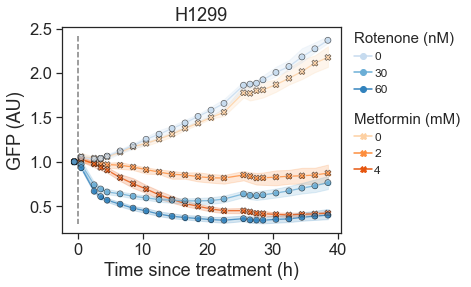

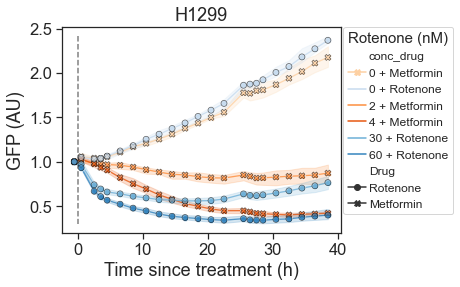

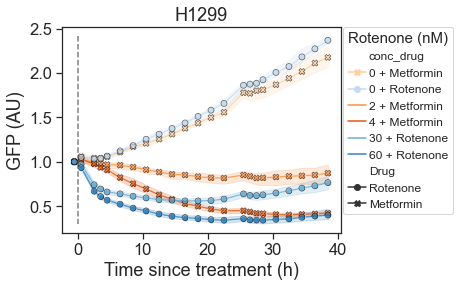

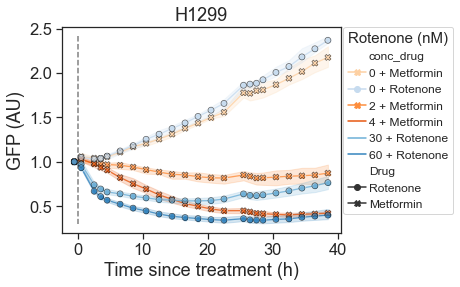

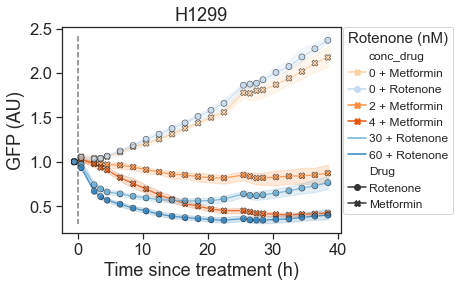

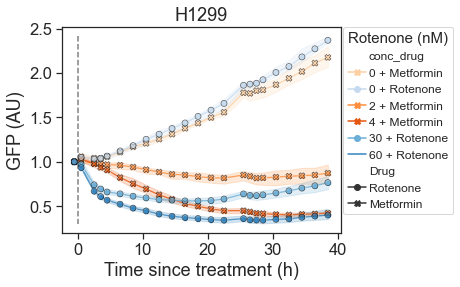

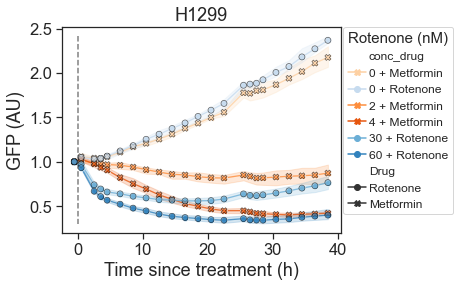

In [14]:
plate_name_sele = 'AS_P22'



row_found = False
for _, row in plate_anno.iterrows():
    if row['Plate name'] == plate_name_sele:
        row_found = True
        break
assert(row_found)
    
fnam, pnam = row['Folder name'], row['Plate name']
Nmes_pre, t_to_mes = row['Nmes pre'], row['Time to mes']

wb_name = '{}/{}/{}_all.xlsx'.format(data_folder, fnam, pnam)
sheet_name = '{}_GFP'.format(pnam)
sheet_name_rfp = '{}_RFP'.format(pnam)
print(wb_name)
#print(sheet_name)
df = pd.read_excel(wb_name, header=1, sheet_name=sheet_name)
# Fix treatment time and mask useless timepoints:
df['Elapsed'] = df['Elapsed'] - df['Elapsed'].values[Nmes_pre] + t_to_mes
time_mask = df['Elapsed'] < row['max time']
df = df[time_mask].copy()

# Find the columns for the plate:
df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
well_ids = natsorted(list(set(df_melt['Well'])))

# Mask timepoint with confluent cells:
df_rfp = pd.read_excel(wb_name, header=1, sheet_name=sheet_name_rfp)
df_rfp = df_rfp[time_mask].copy()
df_rfp.loc[:, well_ids] = df_rfp.loc[:, well_ids] / df_rfp.loc[0, well_ids]

cut_mask = df_rfp.loc[:, well_ids] < row['rfp fold cut']
df.loc[:, well_ids] = df.loc[:, well_ids][cut_mask].copy()


df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_melt = df_melt[~df_melt.isna()].copy()
df_norm = df.copy()
df_norm.loc[:, well_ids] = df.loc[:, well_ids] / df.loc[0, well_ids]
df_norm_melt = df_norm.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_norm_melt = df_norm_melt[~df_norm_melt.isna()].copy()
anno_mask = (well_anno['Folder name'] == fnam) & (well_anno['Plate name'] == pnam)
plate_data = well_anno[anno_mask].merge(df_melt, on='Well').reset_index(drop=True)
plate_data_norm = well_anno[anno_mask].merge(df_norm_melt, on='Well').reset_index(drop=True)
plate_data['GFP/RFP norm'] = plate_data_norm['GFP/RFP'].copy()
# Remove non-included wells:
plate_data = plate_data[plate_data['include']].copy()
grp_cols = list(set(plate_data.columns) - set(['GFP/RFP', 'GFP/RFP norm', 'Well']))
plate_data_avg = plate_data.groupby(grp_cols).agg(GFP_RFP_mean=('GFP/RFP', 'mean'), 
                                                  GFP_RFP_std=('GFP/RFP', 'std'), 
                                                  GFP_RFP_norm_mean=('GFP/RFP norm', 'mean'), 
                                                  GFP_RFP_norm_std=('GFP/RFP norm', 'std')).reset_index()


style = 'Drug'
style_order = ['Rotenone', 'Metformin']
markers = True
pmode = 'GFP/RFP norm'
pmode_avg = 'GFP_RFP_norm_mean'
min_sens = plate_data[pmode].min()
max_sens = plate_data[pmode].max()
hue_order = natsorted(set(plate_data['conc_drug']))

pal = sns.color_palette('tab20c')
pal2 = sns.color_palette(palette=[pal[7], pal[3], pal[5], pal[4], pal[1], pal[0]])

fig, ax1 = plt.subplots(1, 1, figsize=(5, 3.8))
g1 = sns.lineplot(ax=ax1, data=plate_data, y=pmode, x='Elapsed', hue='conc_drug', style='Drug', \
                  zorder=9, alpha=0.8, linewidth=1.3, legend=True, \
                  errorbar=('ci', row['ci']), hue_order=hue_order, style_order=style_order, \
                  markers=True, dashes=[""]*len(style_order), \
                  palette=pal2);

g2 = sns.scatterplot(ax=ax1, data=plate_data_avg, y=pmode_avg, x='Elapsed', hue='conc_drug', \
                     zorder=10, alpha=0.6, edgecolor='black', linewidth=0.7, \
                     legend=False, markers=markers, style=style, \
                     hue_order=hue_order, style_order=style_order, \
                     palette=pal2);

g2.set_ylabel('GFP (AU)');
g2.set_xlabel('Time since treatment (h)');
g2.set_title('H1299');
sns.move_legend(g2, "upper left", bbox_to_anchor=(1.01, 1), frameon=True, ncol=1, \
                alignment='center', labelspacing=0.5, handletextpad=0.2, borderaxespad=0, \
                handlelength=1.5, title='{} ({})'.format(row['Drug'], row['Conc unit']), \
                fontsize=12, title_fontsize=15);

ax1.vlines(0, max_sens, min_sens, ls='--', color='grey');


rot_lh, rot_lt = [], []
met_lh, met_lt = [], []
for lh in ax1.legend_.legendHandles:
    l_txt = lh.get_label().split(' + ')
    if len(l_txt) == 1:
        continue
    if 'Rotenone' in l_txt[1]:
        lh.set_marker('o')
        rot_lh.append(copy.deepcopy(lh))
        rot_lt.append(l_txt[0])
    elif 'Metformin' in l_txt[1]:
        lh.set_marker('X')
        met_lh.append(copy.deepcopy(lh))
        met_lt.append(l_txt[0])

l1 = ax1.legend(rot_lh, rot_lt, loc='upper left', bbox_to_anchor=(1.03, 1), frameon=False, ncol=1, \
                alignment='left', labelspacing=0.5, handletextpad=0.2, borderaxespad=0, \
                handlelength=1.5, title='Rotenone (nM)', fontsize=12, title_fontsize=15)
l2 = ax1.legend(met_lh, met_lt, loc='upper left', bbox_to_anchor=(1.03, 0.61), frameon=False, ncol=1, \
                alignment='left', labelspacing=0.5, handletextpad=0.2, borderaxespad=0, \
                handlelength=1.5, title='Metformin (mM)', fontsize=12, title_fontsize=15)
ax1.add_artist(l1)


pdf_fnam = 'temporal_plots_non-normalized/{}_GFP.pdf'.format(plate_name_sele)
fig.savefig(pdf_fnam, bbox_inches='tight')

IC_data/AS_P22/AS_P22_all.xlsx


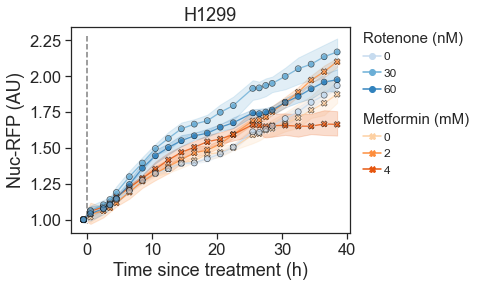

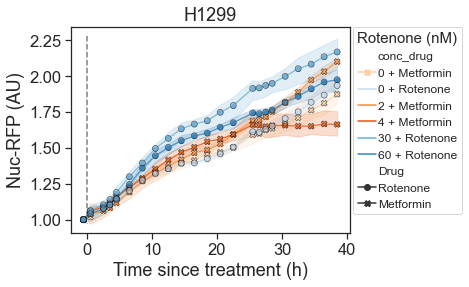

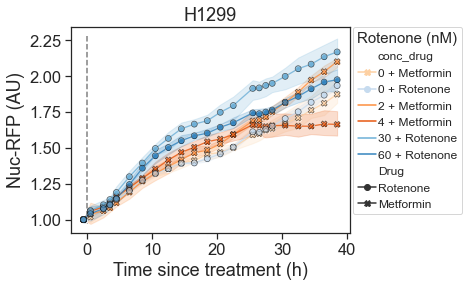

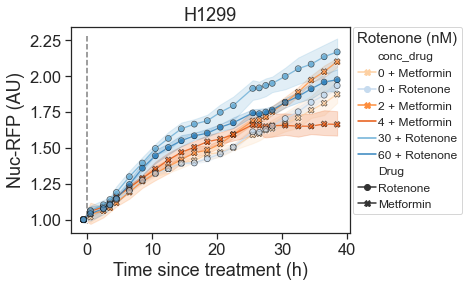

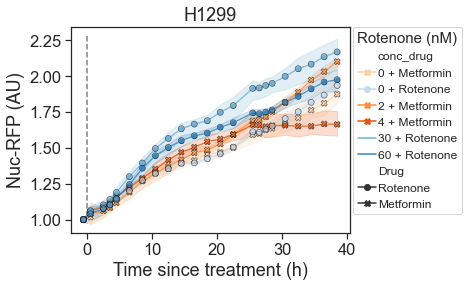

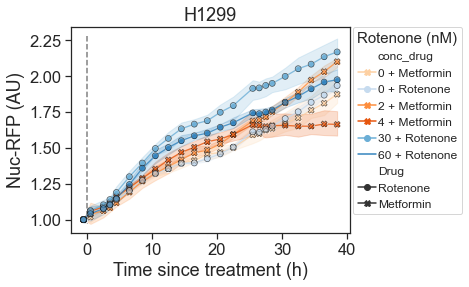

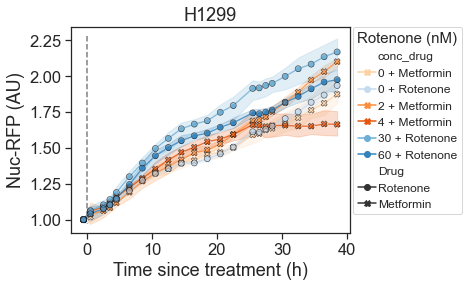

In [15]:
plate_name_sele = 'AS_P22'



row_found = False
for _, row in plate_anno.iterrows():
    if row['Plate name'] == plate_name_sele:
        row_found = True
        break
assert(row_found)
    
fnam, pnam = row['Folder name'], row['Plate name']
Nmes_pre, t_to_mes = row['Nmes pre'], row['Time to mes']

wb_name = '{}/{}/{}_all.xlsx'.format(data_folder, fnam, pnam)
sheet_name = '{}_RFP'.format(pnam)
sheet_name_rfp = '{}_RFP'.format(pnam)
print(wb_name)
#print(sheet_name)
df = pd.read_excel(wb_name, header=1, sheet_name=sheet_name)
# Fix treatment time and mask useless timepoints:
df['Elapsed'] = df['Elapsed'] - df['Elapsed'].values[Nmes_pre] + t_to_mes
time_mask = df['Elapsed'] < row['max time']
df = df[time_mask].copy()

# Find the columns for the plate:
df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
well_ids = natsorted(list(set(df_melt['Well'])))

# Mask timepoint with confluent cells:
df_rfp = pd.read_excel(wb_name, header=1, sheet_name=sheet_name_rfp)
df_rfp = df_rfp[time_mask].copy()
df_rfp.loc[:, well_ids] = df_rfp.loc[:, well_ids] / df_rfp.loc[0, well_ids]

cut_mask = df_rfp.loc[:, well_ids] < row['rfp fold cut']
df.loc[:, well_ids] = df.loc[:, well_ids][cut_mask].copy()


df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_melt = df_melt[~df_melt.isna()].copy()
df_norm = df.copy()
df_norm.loc[:, well_ids] = df.loc[:, well_ids] / df.loc[0, well_ids]
df_norm_melt = df_norm.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_norm_melt = df_norm_melt[~df_norm_melt.isna()].copy()
anno_mask = (well_anno['Folder name'] == fnam) & (well_anno['Plate name'] == pnam)
plate_data = well_anno[anno_mask].merge(df_melt, on='Well').reset_index(drop=True)
plate_data_norm = well_anno[anno_mask].merge(df_norm_melt, on='Well').reset_index(drop=True)
plate_data['GFP/RFP norm'] = plate_data_norm['GFP/RFP'].copy()
# Remove non-included wells:
plate_data = plate_data[plate_data['include']].copy()
grp_cols = list(set(plate_data.columns) - set(['GFP/RFP', 'GFP/RFP norm', 'Well']))
plate_data_avg = plate_data.groupby(grp_cols).agg(GFP_RFP_mean=('GFP/RFP', 'mean'), 
                                                  GFP_RFP_std=('GFP/RFP', 'std'), 
                                                  GFP_RFP_norm_mean=('GFP/RFP norm', 'mean'), 
                                                  GFP_RFP_norm_std=('GFP/RFP norm', 'std')).reset_index()


style = 'Drug'
style_order = ['Rotenone', 'Metformin']
markers = True
pmode = 'GFP/RFP norm'
pmode_avg = 'GFP_RFP_norm_mean'
min_sens = plate_data[pmode].min()
max_sens = plate_data[pmode].max()
hue_order = natsorted(set(plate_data['conc_drug']))

pal = sns.color_palette('tab20c')
pal2 = sns.color_palette(palette=[pal[7], pal[3], pal[5], pal[4], pal[1], pal[0]])

fig, ax1 = plt.subplots(1, 1, figsize=(5, 3.8))
g1 = sns.lineplot(ax=ax1, data=plate_data, y=pmode, x='Elapsed', hue='conc_drug', style='Drug', \
                  zorder=9, alpha=0.8, linewidth=1.3, legend=True, \
                  errorbar=('ci', row['ci']), hue_order=hue_order, style_order=style_order, \
                  markers=True, dashes=[""]*len(style_order), \
                  palette=pal2);

g2 = sns.scatterplot(ax=ax1, data=plate_data_avg, y=pmode_avg, x='Elapsed', hue='conc_drug', \
                     zorder=10, alpha=0.6, edgecolor='black', linewidth=0.7, \
                     legend=False, markers=markers, style=style, \
                     hue_order=hue_order, style_order=style_order, \
                     palette=pal2);

g2.set_ylabel('Nuc-RFP (AU)');
g2.set_xlabel('Time since treatment (h)');
g2.set_title('H1299');
sns.move_legend(g2, "upper left", bbox_to_anchor=(1.01, 1), frameon=True, ncol=1, \
                alignment='center', labelspacing=0.5, handletextpad=0.2, borderaxespad=0, \
                handlelength=1.5, title='{} ({})'.format(row['Drug'], row['Conc unit']), \
                fontsize=12, title_fontsize=15);

ax1.vlines(0, max_sens, min_sens, ls='--', color='grey');


rot_lh, rot_lt = [], []
met_lh, met_lt = [], []
for lh in ax1.legend_.legendHandles:
    l_txt = lh.get_label().split(' + ')
    if len(l_txt) == 1:
        continue
    if 'Rotenone' in l_txt[1]:
        lh.set_marker('o')
        rot_lh.append(copy.deepcopy(lh))
        rot_lt.append(l_txt[0])
    elif 'Metformin' in l_txt[1]:
        lh.set_marker('X')
        met_lh.append(copy.deepcopy(lh))
        met_lt.append(l_txt[0])

l1 = ax1.legend(rot_lh, rot_lt, loc='upper left', bbox_to_anchor=(1.03, 1), frameon=False, ncol=1, \
                alignment='left', labelspacing=0.5, handletextpad=0.2, borderaxespad=0, \
                handlelength=1.5, title='Rotenone (nM)', fontsize=12, title_fontsize=15)
l2 = ax1.legend(met_lh, met_lt, loc='upper left', bbox_to_anchor=(1.03, 0.61), frameon=False, ncol=1, \
                alignment='left', labelspacing=0.5, handletextpad=0.2, borderaxespad=0, \
                handlelength=1.5, title='Metformin (mM)', fontsize=12, title_fontsize=15)
ax1.add_artist(l1)


pdf_fnam = 'temporal_plots_non-normalized/{}_RFP.pdf'.format(plate_name_sele)
fig.savefig(pdf_fnam, bbox_inches='tight')

### H1299 GOT-DKO Nuc-RFP Asp-sens media aspartate titration

IC_data/AS_P6/AS_P6_all.xlsx


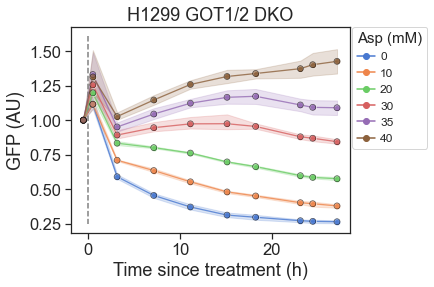

In [18]:
plate_name_sele = 'AS_P6'



row_found = False
for _, row in plate_anno.iterrows():
    if row['Plate name'] == plate_name_sele:
        row_found = True
        break
assert(row_found)
    
fnam, pnam = row['Folder name'], row['Plate name']
Nmes_pre, t_to_mes = row['Nmes pre'], row['Time to mes']

wb_name = '{}/{}/{}_all.xlsx'.format(data_folder, fnam, pnam)
sheet_name = '{}_GFP'.format(pnam)
sheet_name_rfp = '{}_RFP'.format(pnam)
print(wb_name)
#print(sheet_name)
df = pd.read_excel(wb_name, header=1, sheet_name=sheet_name)
# Fix treatment time and mask useless timepoints:
df['Elapsed'] = df['Elapsed'] - df['Elapsed'].values[Nmes_pre] + t_to_mes
time_mask = df['Elapsed'] < row['max time']
df = df[time_mask].copy()

# Find the columns for the plate:
df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
well_ids = natsorted(list(set(df_melt['Well'])))

# Mask timepoint with confluent cells:
df_rfp = pd.read_excel(wb_name, header=1, sheet_name=sheet_name_rfp)
df_rfp = df_rfp[time_mask].copy()
df_rfp.loc[:, well_ids] = df_rfp.loc[:, well_ids] / df_rfp.loc[0, well_ids]

cut_mask = df_rfp.loc[:, well_ids] < row['rfp fold cut']
df.loc[:, well_ids] = df.loc[:, well_ids][cut_mask].copy()


df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_melt = df_melt[~df_melt.isna()].copy()
df_norm = df.copy()
df_norm.loc[:, well_ids] = df.loc[:, well_ids] / df.loc[0, well_ids]
df_norm_melt = df_norm.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_norm_melt = df_norm_melt[~df_norm_melt.isna()].copy()
anno_mask = (well_anno['Folder name'] == fnam) & (well_anno['Plate name'] == pnam)
plate_data = well_anno[anno_mask].merge(df_melt, on='Well').reset_index(drop=True)
plate_data_norm = well_anno[anno_mask].merge(df_norm_melt, on='Well').reset_index(drop=True)
plate_data['GFP/RFP norm'] = plate_data_norm['GFP/RFP'].copy()
# Remove non-included wells:
plate_data = plate_data[plate_data['include']].copy()
grp_cols = list(set(plate_data.columns) - set(['GFP/RFP', 'GFP/RFP norm', 'Well']))
plate_data_avg = plate_data.groupby(grp_cols).agg(GFP_RFP_mean=('GFP/RFP', 'mean'), 
                                                  GFP_RFP_std=('GFP/RFP', 'std'), 
                                                  GFP_RFP_norm_mean=('GFP/RFP norm', 'mean'), 
                                                  GFP_RFP_norm_std=('GFP/RFP norm', 'std')).reset_index()


style = 'Drug'
markers = True
pmode = 'GFP/RFP norm'
pmode_avg = 'GFP_RFP_norm_mean'
min_sens = plate_data[pmode].min()
max_sens = plate_data[pmode].max()
hue_order = natsorted(set(plate_data['conc_res']))

fig, ax1 = plt.subplots(1, 1, figsize=(5, 3.8))
g1 = sns.lineplot(ax=ax1, data=plate_data, y=pmode, x='Elapsed', hue='conc_res', style='conc_res', \
                  zorder=9, alpha=0.8, linewidth=1.3, legend=True, \
                  errorbar=('ci', row['ci']), hue_order=hue_order, \
                  markers=["o"]*len(hue_order), dashes=[""]*len(hue_order))

g2 = sns.scatterplot(ax=ax1, data=plate_data_avg, y=pmode_avg, x='Elapsed', hue='conc_res', \
                     zorder=10, alpha=0.6, edgecolor='black', linewidth=0.7, \
                     legend=False, markers=markers, style=style, hue_order=hue_order)

g2.set_ylabel('GFP (AU)')
g2.set_xlabel('Time since treatment (h)')
g2.set_title('H1299 GOT1/2 DKO')
sns.move_legend(g2, "upper left", bbox_to_anchor=(1.01, 1), frameon=True, ncol=1, \
                alignment='left', labelspacing=0.5, handletextpad=0.4, borderaxespad=0, \
                handlelength=1.5, title='Asp (mM)', fontsize=12, title_fontsize=15)

ax1.vlines(0, max_sens, min_sens, ls='--', color='grey')


pdf_fnam = 'temporal_plots_non-normalized/{}_GFP.pdf'.format(plate_name_sele)
fig.savefig(pdf_fnam, bbox_inches='tight')

IC_data/AS_P6/AS_P6_all.xlsx


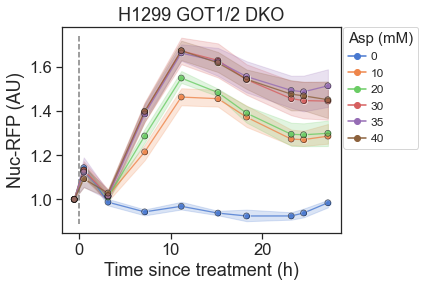

In [19]:
plate_name_sele = 'AS_P6'



row_found = False
for _, row in plate_anno.iterrows():
    if row['Plate name'] == plate_name_sele:
        row_found = True
        break
assert(row_found)
    
fnam, pnam = row['Folder name'], row['Plate name']
Nmes_pre, t_to_mes = row['Nmes pre'], row['Time to mes']

wb_name = '{}/{}/{}_all.xlsx'.format(data_folder, fnam, pnam)
sheet_name = '{}_RFP'.format(pnam)
sheet_name_rfp = '{}_RFP'.format(pnam)
print(wb_name)
#print(sheet_name)
df = pd.read_excel(wb_name, header=1, sheet_name=sheet_name)
# Fix treatment time and mask useless timepoints:
df['Elapsed'] = df['Elapsed'] - df['Elapsed'].values[Nmes_pre] + t_to_mes
time_mask = df['Elapsed'] < row['max time']
df = df[time_mask].copy()

# Find the columns for the plate:
df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
well_ids = natsorted(list(set(df_melt['Well'])))

# Mask timepoint with confluent cells:
df_rfp = pd.read_excel(wb_name, header=1, sheet_name=sheet_name_rfp)
df_rfp = df_rfp[time_mask].copy()
df_rfp.loc[:, well_ids] = df_rfp.loc[:, well_ids] / df_rfp.loc[0, well_ids]

cut_mask = df_rfp.loc[:, well_ids] < row['rfp fold cut']
df.loc[:, well_ids] = df.loc[:, well_ids][cut_mask].copy()


df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_melt = df_melt[~df_melt.isna()].copy()
df_norm = df.copy()
df_norm.loc[:, well_ids] = df.loc[:, well_ids] / df.loc[0, well_ids]
df_norm_melt = df_norm.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_norm_melt = df_norm_melt[~df_norm_melt.isna()].copy()
anno_mask = (well_anno['Folder name'] == fnam) & (well_anno['Plate name'] == pnam)
plate_data = well_anno[anno_mask].merge(df_melt, on='Well').reset_index(drop=True)
plate_data_norm = well_anno[anno_mask].merge(df_norm_melt, on='Well').reset_index(drop=True)
plate_data['GFP/RFP norm'] = plate_data_norm['GFP/RFP'].copy()
# Remove non-included wells:
plate_data = plate_data[plate_data['include']].copy()
grp_cols = list(set(plate_data.columns) - set(['GFP/RFP', 'GFP/RFP norm', 'Well']))
plate_data_avg = plate_data.groupby(grp_cols).agg(GFP_RFP_mean=('GFP/RFP', 'mean'), 
                                                  GFP_RFP_std=('GFP/RFP', 'std'), 
                                                  GFP_RFP_norm_mean=('GFP/RFP norm', 'mean'), 
                                                  GFP_RFP_norm_std=('GFP/RFP norm', 'std')).reset_index()


style = 'Drug'
markers = True
pmode = 'GFP/RFP norm'
pmode_avg = 'GFP_RFP_norm_mean'
min_sens = plate_data[pmode].min()
max_sens = plate_data[pmode].max()
hue_order = natsorted(set(plate_data['conc_res']))

fig, ax1 = plt.subplots(1, 1, figsize=(5, 3.8))
g1 = sns.lineplot(ax=ax1, data=plate_data, y=pmode, x='Elapsed', hue='conc_res', style='conc_res', \
                  zorder=9, alpha=0.8, linewidth=1.3, legend=True, \
                  errorbar=('ci', row['ci']), hue_order=hue_order, \
                  markers=["o"]*len(hue_order), dashes=[""]*len(hue_order))

g2 = sns.scatterplot(ax=ax1, data=plate_data_avg, y=pmode_avg, x='Elapsed', hue='conc_res', \
                     zorder=10, alpha=0.6, edgecolor='black', linewidth=0.7, \
                     legend=False, markers=markers, style=style, hue_order=hue_order)

g2.set_ylabel('Nuc-RFP (AU)')
g2.set_xlabel('Time since treatment (h)')
g2.set_title('H1299 GOT1/2 DKO')
sns.move_legend(g2, "upper left", bbox_to_anchor=(1.01, 1), frameon=True, ncol=1, \
                alignment='left', labelspacing=0.5, handletextpad=0.4, borderaxespad=0, \
                handlelength=1.5, title='Asp (mM)', fontsize=12, title_fontsize=15)

ax1.vlines(0, max_sens, min_sens, ls='--', color='grey')


pdf_fnam = 'temporal_plots_non-normalized/{}_RFP.pdf'.format(plate_name_sele)
fig.savefig(pdf_fnam, bbox_inches='tight')

### H1299 Nuc-RFP Asp-sens glutamine titration w/wo asparagine

IC_data/AS_P13/AS_P13_all.xlsx


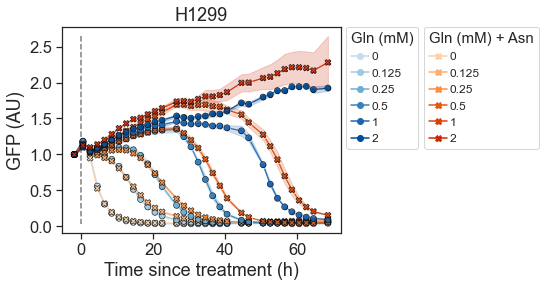

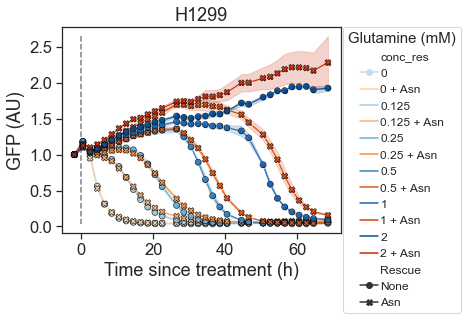

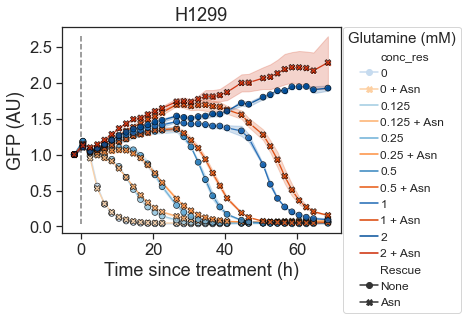

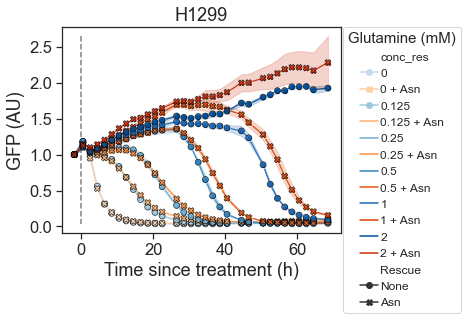

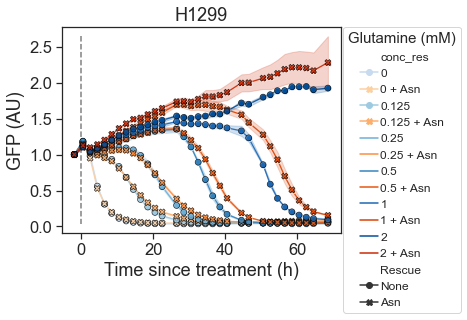

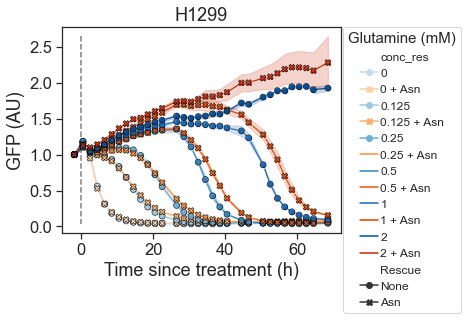

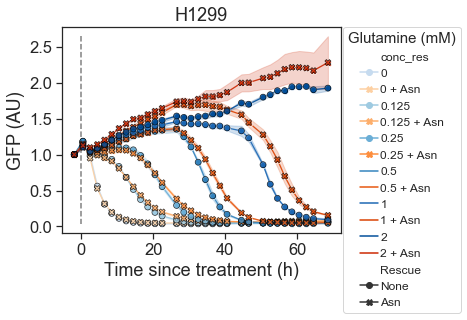

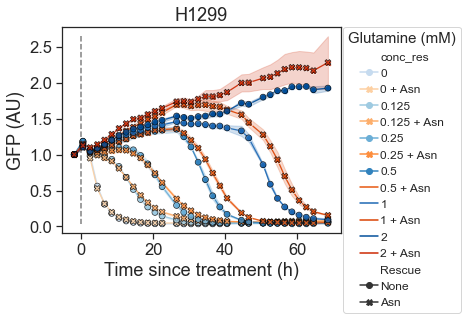

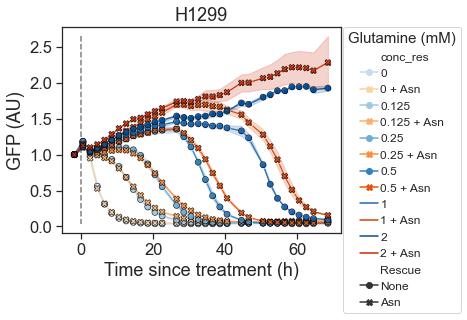

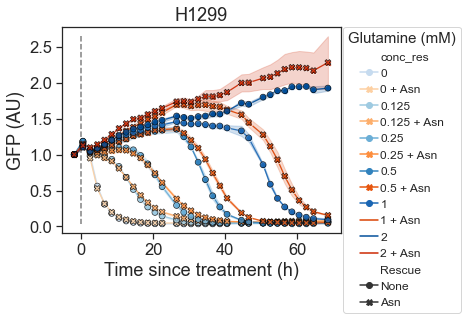

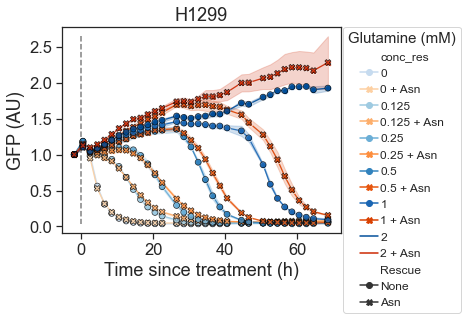

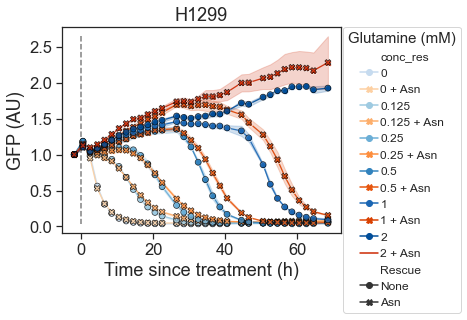

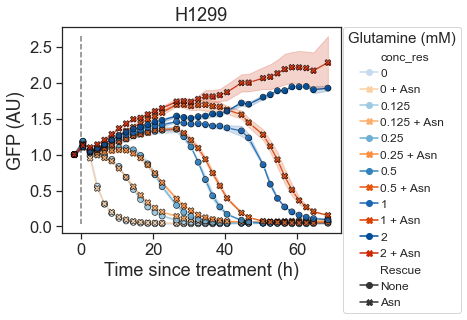

In [20]:
plate_name_sele = 'AS_P13'



row_found = False
for _, row in plate_anno.iterrows():
    if row['Plate name'] == plate_name_sele:
        row_found = True
        break
assert(row_found)
    
fnam, pnam = row['Folder name'], row['Plate name']
Nmes_pre, t_to_mes = row['Nmes pre'], row['Time to mes']

wb_name = '{}/{}/{}_all.xlsx'.format(data_folder, fnam, pnam)
sheet_name = '{}_GFP'.format(pnam)
sheet_name_rfp = '{}_RFP'.format(pnam)
print(wb_name)
#print(sheet_name)
df = pd.read_excel(wb_name, header=1, sheet_name=sheet_name)
# Fix treatment time and mask useless timepoints:
df['Elapsed'] = df['Elapsed'] - df['Elapsed'].values[Nmes_pre] + t_to_mes
time_mask = df['Elapsed'] < row['max time']
df = df[time_mask].copy()

# Find the columns for the plate:
df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
well_ids = natsorted(list(set(df_melt['Well'])))

# Mask timepoint with confluent cells:
df_rfp = pd.read_excel(wb_name, header=1, sheet_name=sheet_name_rfp)
df_rfp = df_rfp[time_mask].copy()
df_rfp.loc[:, well_ids] = df_rfp.loc[:, well_ids] / df_rfp.loc[0, well_ids]

cut_mask = df_rfp.loc[:, well_ids] < row['rfp fold cut']
df.loc[:, well_ids] = df.loc[:, well_ids][cut_mask].copy()


df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_melt = df_melt[~df_melt.isna()].copy()
df_norm = df.copy()
df_norm.loc[:, well_ids] = df.loc[:, well_ids] / df.loc[0, well_ids]
df_norm_melt = df_norm.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_norm_melt = df_norm_melt[~df_norm_melt.isna()].copy()
anno_mask = (well_anno['Folder name'] == fnam) & (well_anno['Plate name'] == pnam)
plate_data = well_anno[anno_mask].merge(df_melt, on='Well').reset_index(drop=True)
plate_data_norm = well_anno[anno_mask].merge(df_norm_melt, on='Well').reset_index(drop=True)
plate_data['GFP/RFP norm'] = plate_data_norm['GFP/RFP'].copy()
# Remove non-included wells:
plate_data = plate_data[plate_data['include']].copy()
grp_cols = list(set(plate_data.columns) - set(['GFP/RFP', 'GFP/RFP norm', 'Well']))
plate_data_avg = plate_data.groupby(grp_cols).agg(GFP_RFP_mean=('GFP/RFP', 'mean'), 
                                                  GFP_RFP_std=('GFP/RFP', 'std'), 
                                                  GFP_RFP_norm_mean=('GFP/RFP norm', 'mean'), 
                                                  GFP_RFP_norm_std=('GFP/RFP norm', 'std')).reset_index()

style_order = ['None', 'Asn']
style = 'Rescue'
markers = True
pmode = 'GFP/RFP norm'
pmode_avg = 'GFP_RFP_norm_mean'
min_sens = plate_data[pmode].min()
max_sens = plate_data[pmode].max()
hue_order = sorted(set(plate_data['conc_res']))

pal = sns.color_palette('tab20c')
pal2 = sns.color_palette(palette=[c for t in zip([*pal[0:4][::-1], (0.1, 0.4, 0.7), (0, 0.3, 0.6)], [*pal[4:8][::-1], (0.85, 0.25, 0), (0.8, 0.15, 0)]) for c in t])

fig, ax1 = plt.subplots(1, 1, figsize=(5, 3.8))
g1 = sns.lineplot(ax=ax1, data=plate_data, y=pmode, x='Elapsed', hue='conc_res', style='Rescue', \
                  zorder=9, alpha=0.9, linewidth=1.3, legend=True, \
                  errorbar=('ci', row['ci']), hue_order=hue_order, \
                  markers=True, dashes=[""]*len(style_order), style_order=style_order, \
                  palette=pal2);

g2 = sns.scatterplot(ax=ax1, data=plate_data_avg, y=pmode_avg, x='Elapsed', hue='conc_res', \
                     zorder=10, alpha=0.8, edgecolor='black', linewidth=0.7, \
                     legend=False, markers=markers, style=style, style_order=style_order, \
                     hue_order=hue_order, \
                     palette=pal2);

g2.set_ylabel('GFP (AU)');
g2.set_xlabel('Time since treatment (h)');
g2.set_title('H1299');
sns.move_legend(g2, "upper left", bbox_to_anchor=(1.01, 1), frameon=True, ncol=1, \
                alignment='center', labelspacing=0.5, handletextpad=0.2, borderaxespad=0, \
                handlelength=1.5, title='{} ({})'.format(row['Drug'], row['Conc unit']), \
                fontsize=12, title_fontsize=15);

ax1.vlines(0, max_sens, min_sens, ls='--', color='grey');


none_lh, none_lt = [], []
asn_lh, asn_lt = [], []
for lh in ax1.legend_.legendHandles:
    l_txt = lh.get_label()
    if 'Asn' in l_txt:
        l_txt = l_txt.split(' + ')
        if len(l_txt) == 1:
            continue
        lh.set_marker('X');
        asn_lh.append(copy.deepcopy(lh))
        asn_lt.append(l_txt[0])
    else:
        try:
            float(l_txt)
        except:
            continue
        lh.set_marker('o');
        none_lh.append(copy.deepcopy(lh))
        none_lt.append(l_txt)

l1 = ax1.legend(none_lh, none_lt, loc='upper left', bbox_to_anchor=(1.02, 1), frameon=True, ncol=1, \
                alignment='left', labelspacing=0.5, handletextpad=0.2, borderaxespad=0, \
                handlelength=1.5, title='Gln (mM)', fontsize=12, title_fontsize=15)
l2 = ax1.legend(asn_lh, asn_lt, loc='upper left', bbox_to_anchor=(1.3, 1), frameon=True, ncol=1, \
                alignment='left', labelspacing=0.5, handletextpad=0.2, borderaxespad=0, \
                handlelength=1.5, title='Gln (mM) + Asn', fontsize=12, title_fontsize=15)
ax1.add_artist(l1)


pdf_fnam = 'temporal_plots_non-normalized/{}_GFP.pdf'.format(plate_name_sele)
fig.savefig(pdf_fnam, bbox_inches='tight')

IC_data/AS_P13/AS_P13_all.xlsx


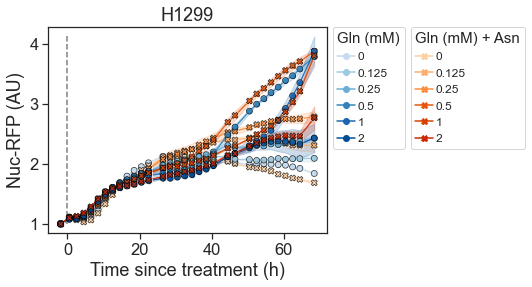

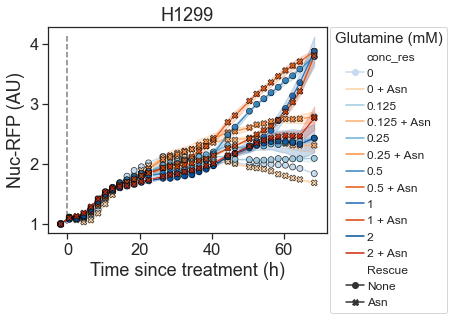

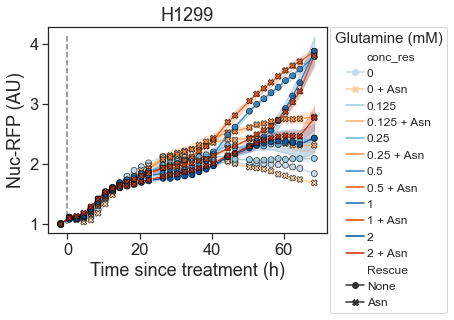

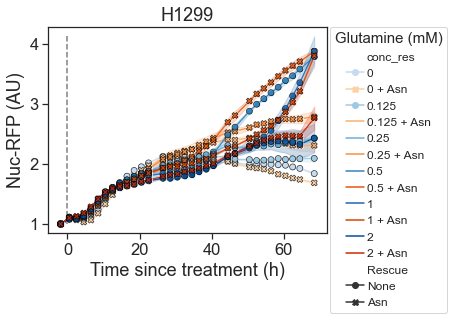

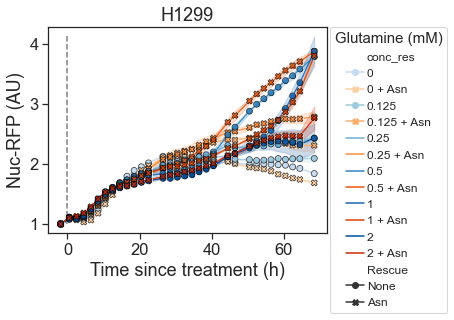

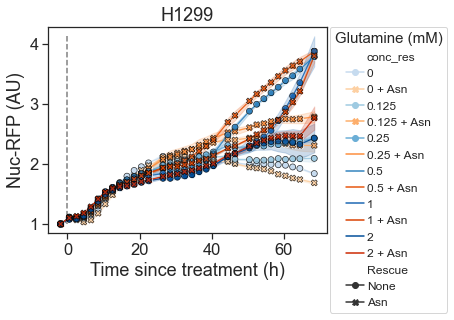

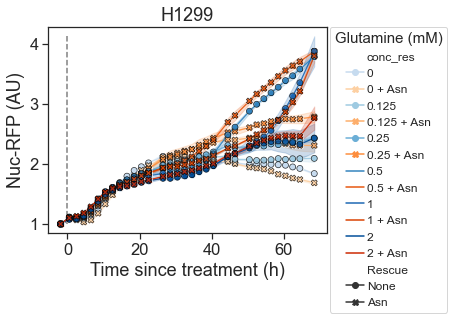

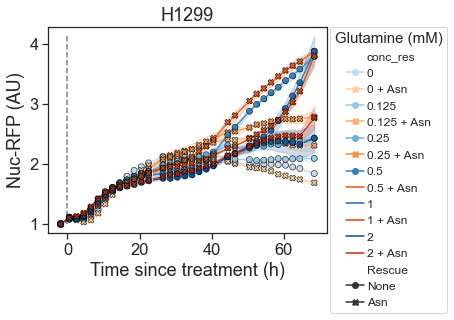

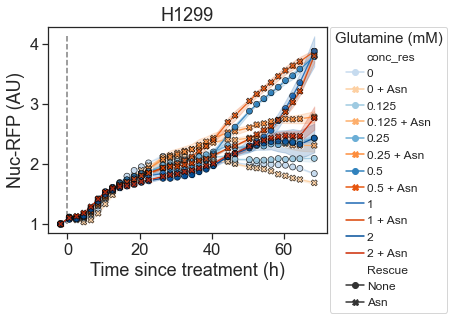

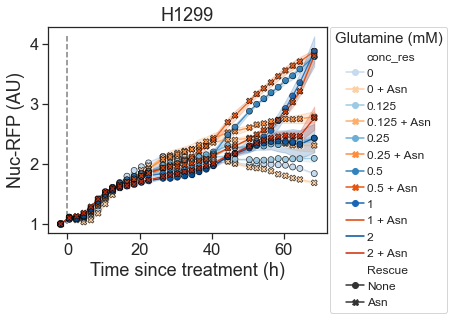

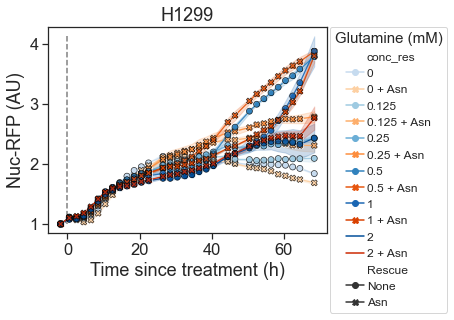

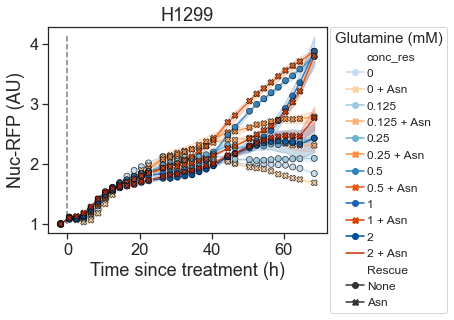

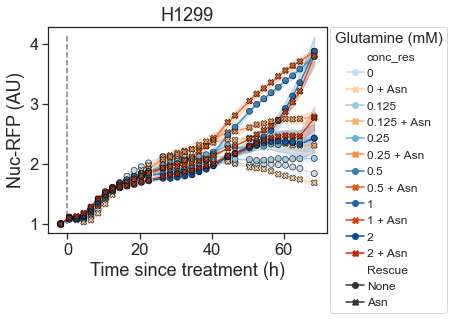

In [21]:
plate_name_sele = 'AS_P13'



row_found = False
for _, row in plate_anno.iterrows():
    if row['Plate name'] == plate_name_sele:
        row_found = True
        break
assert(row_found)
    
fnam, pnam = row['Folder name'], row['Plate name']
Nmes_pre, t_to_mes = row['Nmes pre'], row['Time to mes']

wb_name = '{}/{}/{}_all.xlsx'.format(data_folder, fnam, pnam)
sheet_name = '{}_RFP'.format(pnam)
sheet_name_rfp = '{}_RFP'.format(pnam)
print(wb_name)
#print(sheet_name)
df = pd.read_excel(wb_name, header=1, sheet_name=sheet_name)
# Fix treatment time and mask useless timepoints:
df['Elapsed'] = df['Elapsed'] - df['Elapsed'].values[Nmes_pre] + t_to_mes
time_mask = df['Elapsed'] < row['max time']
df = df[time_mask].copy()

# Find the columns for the plate:
df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
well_ids = natsorted(list(set(df_melt['Well'])))

# Mask timepoint with confluent cells:
df_rfp = pd.read_excel(wb_name, header=1, sheet_name=sheet_name_rfp)
df_rfp = df_rfp[time_mask].copy()
df_rfp.loc[:, well_ids] = df_rfp.loc[:, well_ids] / df_rfp.loc[0, well_ids]

cut_mask = df_rfp.loc[:, well_ids] < row['rfp fold cut']
df.loc[:, well_ids] = df.loc[:, well_ids][cut_mask].copy()


df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_melt = df_melt[~df_melt.isna()].copy()
df_norm = df.copy()
df_norm.loc[:, well_ids] = df.loc[:, well_ids] / df.loc[0, well_ids]
df_norm_melt = df_norm.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_norm_melt = df_norm_melt[~df_norm_melt.isna()].copy()
anno_mask = (well_anno['Folder name'] == fnam) & (well_anno['Plate name'] == pnam)
plate_data = well_anno[anno_mask].merge(df_melt, on='Well').reset_index(drop=True)
plate_data_norm = well_anno[anno_mask].merge(df_norm_melt, on='Well').reset_index(drop=True)
plate_data['GFP/RFP norm'] = plate_data_norm['GFP/RFP'].copy()
# Remove non-included wells:
plate_data = plate_data[plate_data['include']].copy()
grp_cols = list(set(plate_data.columns) - set(['GFP/RFP', 'GFP/RFP norm', 'Well']))
plate_data_avg = plate_data.groupby(grp_cols).agg(GFP_RFP_mean=('GFP/RFP', 'mean'), 
                                                  GFP_RFP_std=('GFP/RFP', 'std'), 
                                                  GFP_RFP_norm_mean=('GFP/RFP norm', 'mean'), 
                                                  GFP_RFP_norm_std=('GFP/RFP norm', 'std')).reset_index()

style_order = ['None', 'Asn']
style = 'Rescue'
markers = True
pmode = 'GFP/RFP norm'
pmode_avg = 'GFP_RFP_norm_mean'
min_sens = plate_data[pmode].min()
max_sens = plate_data[pmode].max()
hue_order = sorted(set(plate_data['conc_res']))

pal = sns.color_palette('tab20c')
pal2 = sns.color_palette(palette=[c for t in zip([*pal[0:4][::-1], (0.1, 0.4, 0.7), (0, 0.3, 0.6)], [*pal[4:8][::-1], (0.85, 0.25, 0), (0.8, 0.15, 0)]) for c in t])

fig, ax1 = plt.subplots(1, 1, figsize=(5, 3.8))
g1 = sns.lineplot(ax=ax1, data=plate_data, y=pmode, x='Elapsed', hue='conc_res', style='Rescue', \
                  zorder=9, alpha=0.9, linewidth=1.3, legend=True, \
                  errorbar=('ci', row['ci']), hue_order=hue_order, \
                  markers=True, dashes=[""]*len(style_order), style_order=style_order, \
                  palette=pal2);

g2 = sns.scatterplot(ax=ax1, data=plate_data_avg, y=pmode_avg, x='Elapsed', hue='conc_res', \
                     zorder=10, alpha=0.8, edgecolor='black', linewidth=0.7, \
                     legend=False, markers=markers, style=style, style_order=style_order, \
                     hue_order=hue_order, \
                     palette=pal2);

g2.set_ylabel('Nuc-RFP (AU)');
g2.set_xlabel('Time since treatment (h)');
g2.set_title('H1299');
sns.move_legend(g2, "upper left", bbox_to_anchor=(1.01, 1), frameon=True, ncol=1, \
                alignment='center', labelspacing=0.5, handletextpad=0.2, borderaxespad=0, \
                handlelength=1.5, title='{} ({})'.format(row['Drug'], row['Conc unit']), \
                fontsize=12, title_fontsize=15);

ax1.vlines(0, max_sens, min_sens, ls='--', color='grey');


none_lh, none_lt = [], []
asn_lh, asn_lt = [], []
for lh in ax1.legend_.legendHandles:
    l_txt = lh.get_label()
    if 'Asn' in l_txt:
        l_txt = l_txt.split(' + ')
        if len(l_txt) == 1:
            continue
        lh.set_marker('X');
        asn_lh.append(copy.deepcopy(lh))
        asn_lt.append(l_txt[0])
    else:
        try:
            float(l_txt)
        except:
            continue
        lh.set_marker('o');
        none_lh.append(copy.deepcopy(lh))
        none_lt.append(l_txt)

l1 = ax1.legend(none_lh, none_lt, loc='upper left', bbox_to_anchor=(1.02, 1), frameon=True, ncol=1, \
                alignment='left', labelspacing=0.5, handletextpad=0.2, borderaxespad=0, \
                handlelength=1.5, title='Gln (mM)', fontsize=12, title_fontsize=15)
l2 = ax1.legend(asn_lh, asn_lt, loc='upper left', bbox_to_anchor=(1.3, 1), frameon=True, ncol=1, \
                alignment='left', labelspacing=0.5, handletextpad=0.2, borderaxespad=0, \
                handlelength=1.5, title='Gln (mM) + Asn', fontsize=12, title_fontsize=15)
ax1.add_artist(l1)


pdf_fnam = 'temporal_plots_non-normalized/{}_RFP.pdf'.format(plate_name_sele)
fig.savefig(pdf_fnam, bbox_inches='tight')

### H1299 Nuc-RFP Asp-sens glutamine titration w/wo asparagine - narrow range

IC_data/AS_P25/AS_P25_all.xlsx


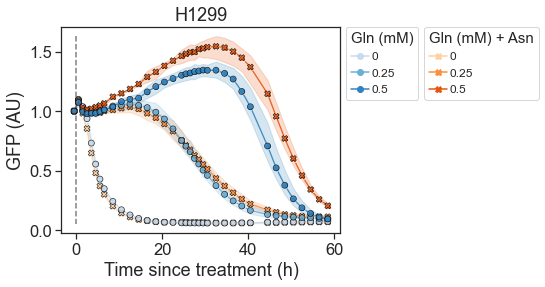

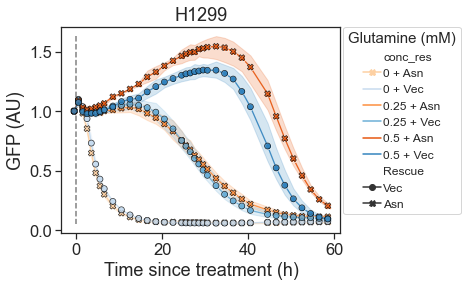

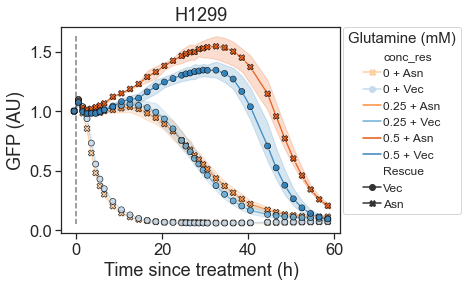

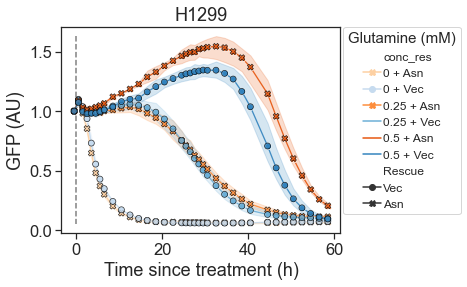

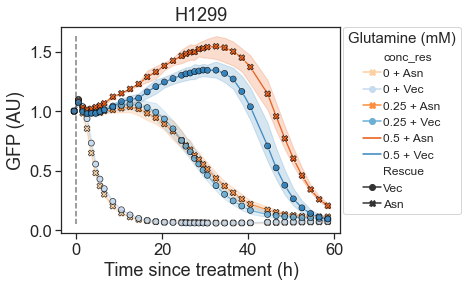

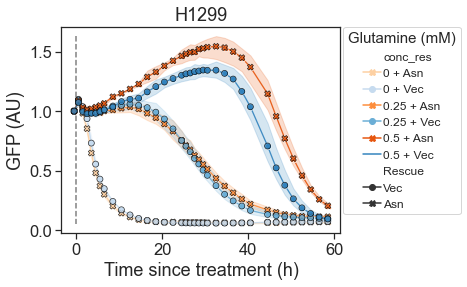

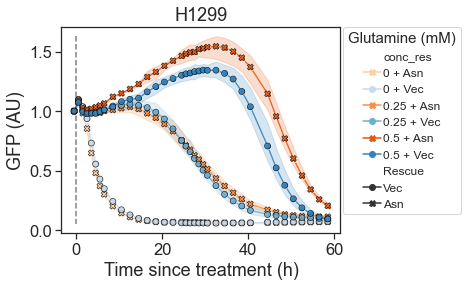

In [24]:
plate_name_sele = 'AS_P25'



row_found = False
for _, row in plate_anno.iterrows():
    if row['Plate name'] == plate_name_sele:
        row_found = True
        break
assert(row_found)
    
fnam, pnam = row['Folder name'], row['Plate name']
Nmes_pre, t_to_mes = row['Nmes pre'], row['Time to mes']

wb_name = '{}/{}/{}_all.xlsx'.format(data_folder, fnam, pnam)
sheet_name = '{}_GFP'.format(pnam)
sheet_name_rfp = '{}_RFP'.format(pnam)
print(wb_name)
#print(sheet_name)
df = pd.read_excel(wb_name, header=1, sheet_name=sheet_name)
# Fix treatment time and mask useless timepoints:
df['Elapsed'] = df['Elapsed'] - df['Elapsed'].values[Nmes_pre] + t_to_mes
time_mask = df['Elapsed'] < row['max time']
df = df[time_mask].copy()

# Find the columns for the plate:
df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
well_ids = natsorted(list(set(df_melt['Well'])))

# Mask timepoint with confluent cells:
df_rfp = pd.read_excel(wb_name, header=1, sheet_name=sheet_name_rfp)
df_rfp = df_rfp[time_mask].copy()
df_rfp.loc[:, well_ids] = df_rfp.loc[:, well_ids] / df_rfp.loc[0, well_ids]

cut_mask = df_rfp.loc[:, well_ids] < row['rfp fold cut']
df.loc[:, well_ids] = df.loc[:, well_ids][cut_mask].copy()


df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_melt = df_melt[~df_melt.isna()].copy()
df_norm = df.copy()
df_norm.loc[:, well_ids] = df.loc[:, well_ids] / df.loc[0, well_ids]
df_norm_melt = df_norm.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_norm_melt = df_norm_melt[~df_norm_melt.isna()].copy()
anno_mask = (well_anno['Folder name'] == fnam) & (well_anno['Plate name'] == pnam)
plate_data = well_anno[anno_mask].merge(df_melt, on='Well').reset_index(drop=True)
plate_data_norm = well_anno[anno_mask].merge(df_norm_melt, on='Well').reset_index(drop=True)
plate_data['GFP/RFP norm'] = plate_data_norm['GFP/RFP'].copy()
# Remove non-included wells:
plate_data = plate_data[plate_data['include']].copy()
grp_cols = list(set(plate_data.columns) - set(['GFP/RFP', 'GFP/RFP norm', 'Well']))
plate_data_avg = plate_data.groupby(grp_cols).agg(GFP_RFP_mean=('GFP/RFP', 'mean'), 
                                                  GFP_RFP_std=('GFP/RFP', 'std'), 
                                                  GFP_RFP_norm_mean=('GFP/RFP norm', 'mean'), 
                                                  GFP_RFP_norm_std=('GFP/RFP norm', 'std')).reset_index()

style_order = ['Vec', 'Asn']
style = 'Rescue'
markers = True
pmode = 'GFP/RFP norm'
pmode_avg = 'GFP_RFP_norm_mean'
min_sens = plate_data[pmode].min()
max_sens = plate_data[pmode].max()
hue_order = sorted(set(plate_data['conc_res']))

pal = sns.color_palette('tab20c')
pal2 = sns.color_palette(palette=[pal[7], pal[3], pal[5], pal[1], pal[4], pal[0]])

fig, ax1 = plt.subplots(1, 1, figsize=(5, 3.8))
g1 = sns.lineplot(ax=ax1, data=plate_data, y=pmode, x='Elapsed', hue='conc_res', style='Rescue', \
                  zorder=9, alpha=0.9, linewidth=1.3, legend=True, \
                  errorbar=('ci', row['ci']), hue_order=hue_order, \
                  markers=True, dashes=[""]*len(style_order), style_order=style_order, \
                  palette=pal2);

g2 = sns.scatterplot(ax=ax1, data=plate_data_avg, y=pmode_avg, x='Elapsed', hue='conc_res', \
                     zorder=10, alpha=0.8, edgecolor='black', linewidth=0.7, \
                     legend=False, markers=markers, style=style, style_order=style_order, \
                     hue_order=hue_order, \
                     palette=pal2);

g2.set_ylabel('GFP (AU)');
g2.set_xlabel('Time since treatment (h)');
g2.set_title('H1299');
sns.move_legend(g2, "upper left", bbox_to_anchor=(1.01, 1), frameon=True, ncol=1, \
                alignment='center', labelspacing=0.5, handletextpad=0.2, borderaxespad=0, \
                handlelength=1.5, title='{} ({})'.format(row['Drug'], row['Conc unit']), \
                fontsize=12, title_fontsize=15);

ax1.vlines(0, max_sens, min_sens, ls='--', color='grey');


none_lh, none_lt = [], []
asn_lh, asn_lt = [], []
for lh in ax1.legend_.legendHandles:
    l_txt = lh.get_label()
    if 'Asn' in l_txt:
        l_txt = l_txt.split(' + ')
        if len(l_txt) == 1:
            continue
        lh.set_marker('X');
        asn_lh.append(copy.deepcopy(lh))
        asn_lt.append(l_txt[0])
    elif 'Vec' in l_txt:
        l_txt = l_txt.split(' + ')
        if len(l_txt) == 1:
            continue
        lh.set_marker('o');
        none_lh.append(copy.deepcopy(lh))
        none_lt.append(l_txt[0])

l1 = ax1.legend(none_lh, none_lt, loc='upper left', bbox_to_anchor=(1.02, 1), frameon=True, ncol=1, \
                alignment='left', labelspacing=0.5, handletextpad=0.2, borderaxespad=0, \
                handlelength=1.5, title='Gln (mM)', fontsize=12, title_fontsize=15)
l2 = ax1.legend(asn_lh, asn_lt, loc='upper left', bbox_to_anchor=(1.3, 1), frameon=True, ncol=1, \
                alignment='left', labelspacing=0.5, handletextpad=0.2, borderaxespad=0, \
                handlelength=1.5, title='Gln (mM) + Asn', fontsize=12, title_fontsize=15)
ax1.add_artist(l1)


pdf_fnam = 'temporal_plots_non-normalized/{}_GFP.pdf'.format(plate_name_sele)
fig.savefig(pdf_fnam, bbox_inches='tight')

IC_data/AS_P25/AS_P25_all.xlsx


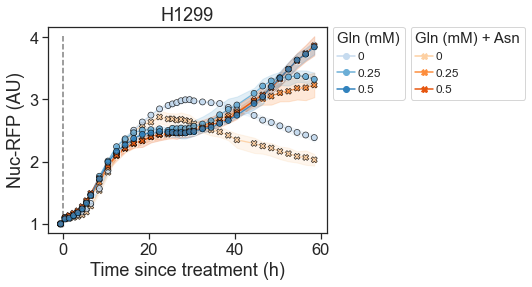

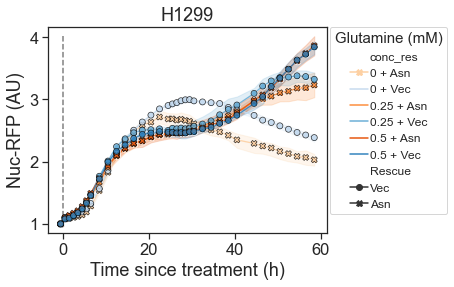

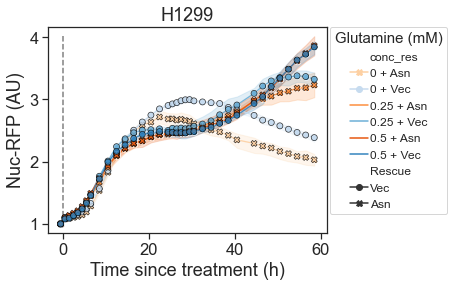

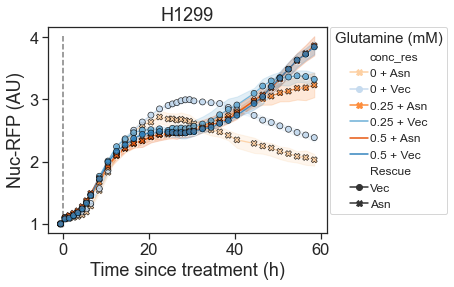

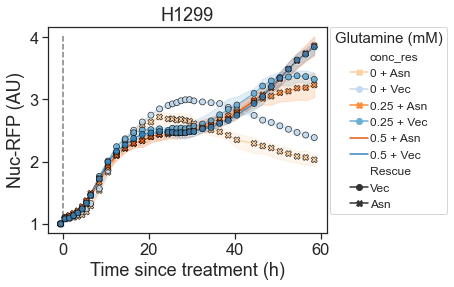

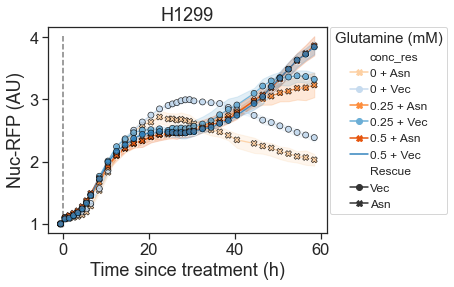

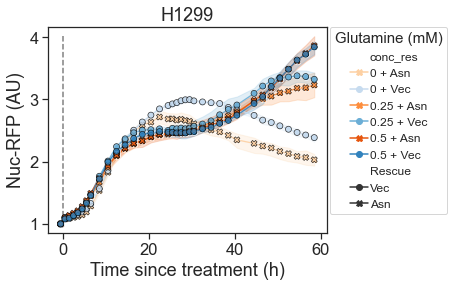

In [25]:
plate_name_sele = 'AS_P25'



row_found = False
for _, row in plate_anno.iterrows():
    if row['Plate name'] == plate_name_sele:
        row_found = True
        break
assert(row_found)
    
fnam, pnam = row['Folder name'], row['Plate name']
Nmes_pre, t_to_mes = row['Nmes pre'], row['Time to mes']

wb_name = '{}/{}/{}_all.xlsx'.format(data_folder, fnam, pnam)
sheet_name = '{}_RFP'.format(pnam)
sheet_name_rfp = '{}_RFP'.format(pnam)
print(wb_name)
#print(sheet_name)
df = pd.read_excel(wb_name, header=1, sheet_name=sheet_name)
# Fix treatment time and mask useless timepoints:
df['Elapsed'] = df['Elapsed'] - df['Elapsed'].values[Nmes_pre] + t_to_mes
time_mask = df['Elapsed'] < row['max time']
df = df[time_mask].copy()

# Find the columns for the plate:
df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
well_ids = natsorted(list(set(df_melt['Well'])))

# Mask timepoint with confluent cells:
df_rfp = pd.read_excel(wb_name, header=1, sheet_name=sheet_name_rfp)
df_rfp = df_rfp[time_mask].copy()
df_rfp.loc[:, well_ids] = df_rfp.loc[:, well_ids] / df_rfp.loc[0, well_ids]

cut_mask = df_rfp.loc[:, well_ids] < row['rfp fold cut']
df.loc[:, well_ids] = df.loc[:, well_ids][cut_mask].copy()


df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_melt = df_melt[~df_melt.isna()].copy()
df_norm = df.copy()
df_norm.loc[:, well_ids] = df.loc[:, well_ids] / df.loc[0, well_ids]
df_norm_melt = df_norm.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_norm_melt = df_norm_melt[~df_norm_melt.isna()].copy()
anno_mask = (well_anno['Folder name'] == fnam) & (well_anno['Plate name'] == pnam)
plate_data = well_anno[anno_mask].merge(df_melt, on='Well').reset_index(drop=True)
plate_data_norm = well_anno[anno_mask].merge(df_norm_melt, on='Well').reset_index(drop=True)
plate_data['GFP/RFP norm'] = plate_data_norm['GFP/RFP'].copy()
# Remove non-included wells:
plate_data = plate_data[plate_data['include']].copy()
grp_cols = list(set(plate_data.columns) - set(['GFP/RFP', 'GFP/RFP norm', 'Well']))
plate_data_avg = plate_data.groupby(grp_cols).agg(GFP_RFP_mean=('GFP/RFP', 'mean'), 
                                                  GFP_RFP_std=('GFP/RFP', 'std'), 
                                                  GFP_RFP_norm_mean=('GFP/RFP norm', 'mean'), 
                                                  GFP_RFP_norm_std=('GFP/RFP norm', 'std')).reset_index()

style_order = ['Vec', 'Asn']
style = 'Rescue'
markers = True
pmode = 'GFP/RFP norm'
pmode_avg = 'GFP_RFP_norm_mean'
min_sens = plate_data[pmode].min()
max_sens = plate_data[pmode].max()
hue_order = sorted(set(plate_data['conc_res']))

pal = sns.color_palette('tab20c')
pal2 = sns.color_palette(palette=[pal[7], pal[3], pal[5], pal[1], pal[4], pal[0]])

fig, ax1 = plt.subplots(1, 1, figsize=(5, 3.8))
g1 = sns.lineplot(ax=ax1, data=plate_data, y=pmode, x='Elapsed', hue='conc_res', style='Rescue', \
                  zorder=9, alpha=0.9, linewidth=1.3, legend=True, \
                  errorbar=('ci', row['ci']), hue_order=hue_order, \
                  markers=True, dashes=[""]*len(style_order), style_order=style_order, \
                  palette=pal2);

g2 = sns.scatterplot(ax=ax1, data=plate_data_avg, y=pmode_avg, x='Elapsed', hue='conc_res', \
                     zorder=10, alpha=0.8, edgecolor='black', linewidth=0.7, \
                     legend=False, markers=markers, style=style, style_order=style_order, \
                     hue_order=hue_order, \
                     palette=pal2);

g2.set_ylabel('Nuc-RFP (AU)');
g2.set_xlabel('Time since treatment (h)');
g2.set_title('H1299');
sns.move_legend(g2, "upper left", bbox_to_anchor=(1.01, 1), frameon=True, ncol=1, \
                alignment='center', labelspacing=0.5, handletextpad=0.2, borderaxespad=0, \
                handlelength=1.5, title='{} ({})'.format(row['Drug'], row['Conc unit']), \
                fontsize=12, title_fontsize=15);

ax1.vlines(0, max_sens, min_sens, ls='--', color='grey');


none_lh, none_lt = [], []
asn_lh, asn_lt = [], []
for lh in ax1.legend_.legendHandles:
    l_txt = lh.get_label()
    if 'Asn' in l_txt:
        l_txt = l_txt.split(' + ')
        if len(l_txt) == 1:
            continue
        lh.set_marker('X');
        asn_lh.append(copy.deepcopy(lh))
        asn_lt.append(l_txt[0])
    elif 'Vec' in l_txt:
        l_txt = l_txt.split(' + ')
        if len(l_txt) == 1:
            continue
        lh.set_marker('o');
        none_lh.append(copy.deepcopy(lh))
        none_lt.append(l_txt[0])

l1 = ax1.legend(none_lh, none_lt, loc='upper left', bbox_to_anchor=(1.02, 1), frameon=True, ncol=1, \
                alignment='left', labelspacing=0.5, handletextpad=0.2, borderaxespad=0, \
                handlelength=1.5, title='Gln (mM)', fontsize=12, title_fontsize=15)
l2 = ax1.legend(asn_lh, asn_lt, loc='upper left', bbox_to_anchor=(1.3, 1), frameon=True, ncol=1, \
                alignment='left', labelspacing=0.5, handletextpad=0.2, borderaxespad=0, \
                handlelength=1.5, title='Gln (mM) + Asn', fontsize=12, title_fontsize=15)
ax1.add_artist(l1)


pdf_fnam = 'temporal_plots_non-normalized/{}_RFP.pdf'.format(plate_name_sele)
fig.savefig(pdf_fnam, bbox_inches='tight')